<h1>Problem description</h1>
<a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">kaggle: Predict Future Sales</a>

<h2> Data fields </h2>
<li>ID - an Id that represents a (Shop, Item) tuple within the test set</li>
<li>shop_id - unique identifier of a shop</li>
<li>item_id - unique identifier of a product</li>
<li>item_category_id - unique identifier of item category</li>
<li>item_cnt_day - number of products sold. You are predicting a monthly amount of this measure</li>
<li>item_price - current price of an item</li>
<li>date - date in format dd/mm/yyyy</li>
<li>date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33</li>
<li>item_name - name of item</li>
<li>shop_name - name of shop</li>
<li>item_category_name - name of item category</li>

<h1> Load Modules </h1>

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h1> Load data </h1>

In [0]:
train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')

<h1> Exploratory Data Analysis </h1>

In [0]:
def display_missing(df): 
    print("----------Missing value-----------")   
    for col in df.columns.tolist():          
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

def display_null(df):
    print("----------Null value-----------")    
    for col in df.columns.tolist():         
        print('{} column null values: {}'.format(col, df[col].isna().sum()))
    print('\n')

In [5]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [7]:
display_missing(train)
display_null(train)

----------Missing value-----------
date column missing values: 0
date_block_num column missing values: 0
shop_id column missing values: 0
item_id column missing values: 0
item_price column missing values: 0
item_cnt_day column missing values: 0


----------Null value-----------
date column null values: 0
date_block_num column null values: 0
shop_id column null values: 0
item_id column null values: 0
item_price column null values: 0
item_cnt_day column null values: 0




In [8]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


<h2>Outliers</h2>

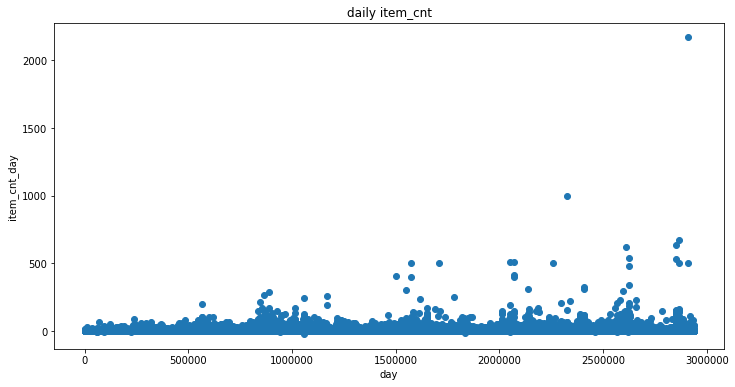

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(range(len(train['item_cnt_day'])),train['item_cnt_day'])
plt.xlabel("day")
plt.ylabel("item_cnt_day")
plt.title("daily item_cnt")
plt.show()

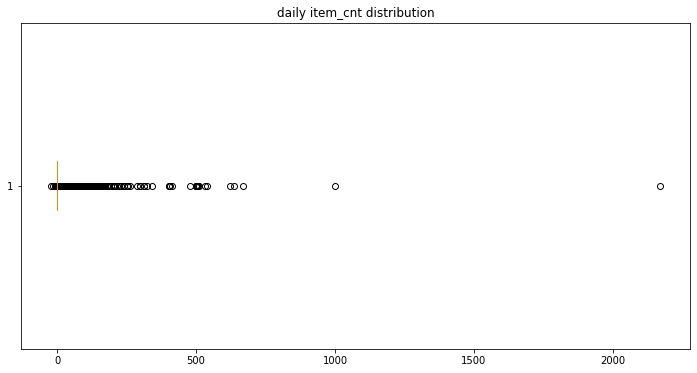

In [10]:
plt.figure(figsize=(12,6))
plt.title("daily item_cnt distribution")
plt.boxplot(x=train['item_cnt_day'], vert=False)
plt.show()

In [11]:
train[train['item_cnt_day'] > 999]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2326930,15.01.2015,24,12,20949,4.000000,1000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0


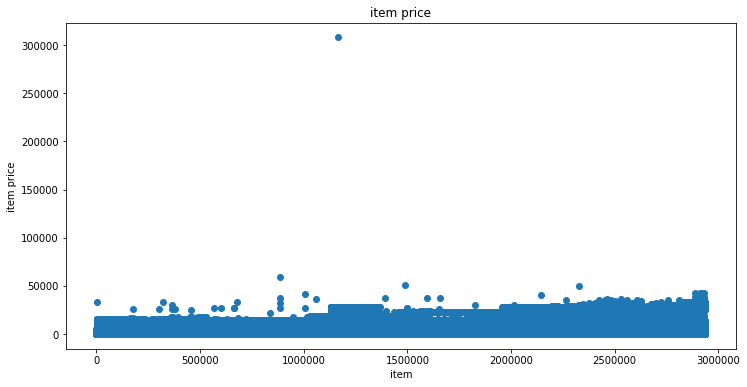

In [12]:
plt.figure(figsize=(12,6))
plt.scatter(range(len(train['item_price'])),train['item_price'])
plt.xlabel("item")
plt.ylabel("item price")
plt.title("item price")
plt.show()

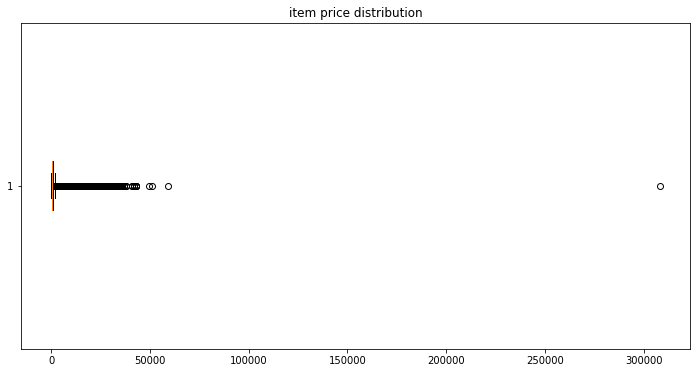

In [13]:
plt.figure(figsize=(12,6))
plt.title("item price distribution")
plt.boxplot(train['item_price'], vert=False)
plt.show()

In [14]:
train[train['item_price'] <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


<p>From the statistical data and the plot, we see that there're some strange data, e.g. item price > 300000, item cnt day = 2169, which should be removed.</p>
<p>There's one item with price below zero, which can be a typo. We fill it with the median value of the price for the same item in the same shop.</p>

In [0]:
train = train[train['item_price']<100000]
train = train[train['item_cnt_day']<1001]

In [0]:
med = train[(train['shop_id'] == 32) & (train['item_id'] == 2973) & (train['date_block_num']==4) & (train['item_price'] > 0)].item_price.median()
train.loc[train['item_price'] <= 0, 'item_price'] = med

In [17]:
# check result
train.iloc[484683]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price              1874
item_cnt_day               1
Name: 484683, dtype: object

<h2>Check and remove duplicates</h2>

In [18]:
train[train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [0]:
train.drop_duplicates(keep='first', inplace=True)

<h2>Monthly sales trend</h2>

In [20]:
train_eda_monthly = train.sort_values('date').groupby(['date_block_num']).agg({'item_cnt_day' : ['sum']})
train_eda_monthly.columns = ['item_cnt_month']
train_eda_monthly.reset_index(inplace=True)

train_eda_monthly.head()

,date_block_num,item_cnt_month
0,0,131478.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0


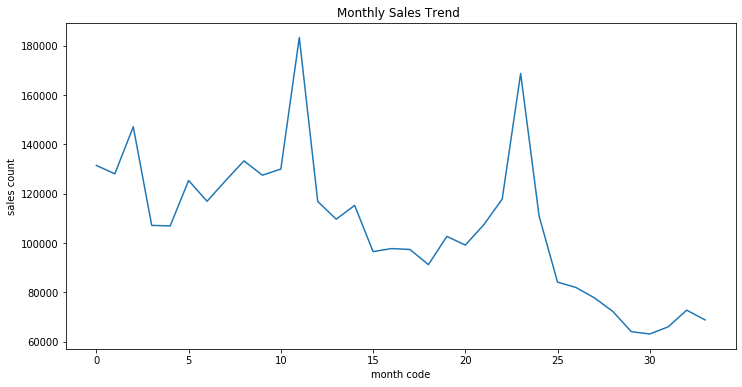

In [21]:
plt.figure(figsize=(12,6))
plt.plot(train_eda_monthly['date_block_num'], train_eda_monthly['item_cnt_month'] )  
plt.title("Monthly Sales Trend ")
plt.xlabel('month code')
plt.ylabel('sales count')
plt.show()

<p>There're peaks in the curves, which shows the seasonality. So month should be add as a feature.</p>

<p>Normal way to extract the month from date can be:</p>
<p>train['month'] = train['date'].apply(lambda x: datetime.strptime(x, '%d.%m.%Y').month)</p>
<p>In this problem, since 'date_block_num' is given, an easier way to get month can be: train['month] = train['date_block_num] % 12 + 1</p>

<h2>Explore shops, item categories, and items</h2>
<p>From google translation, we can see that: </p>
<li>The shop names start with a city name.</li>
<li>A category name contains type and subtype.</li>

In [22]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [0]:
shops.loc[shops.shop_name=='Сергиев Посад ТЦ "7Я"','shop_name']='СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').apply(lambda x: x[0])
shops.loc[shops.city=='!Якутск','city'] = 'Якутск'

In [0]:
shops['city_id'] = LabelEncoder().fit_transform(shops['city'])

In [0]:
shops = shops[['shop_id','city_id']]

In [26]:
shops.head()

,shop_id,city_id
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [27]:
item_categories.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [0]:
item_categories['cats_tmp'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['cats_tmp'].apply(lambda x:x[0].strip())

In [0]:
item_categories['type_id'] = LabelEncoder().fit_transform(item_categories['type'])
# if subtype is nan then type
item_categories['subtype'] = item_categories['cats_tmp'].apply(lambda x:x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_id'] = LabelEncoder().fit_transform(item_categories['subtype'])

item_categories = item_categories[['item_category_id','type_id','subtype_id']]
items.drop(columns=['item_name'],inplace=True)

In [0]:
train_eda = pd.merge(train, shops, on=['shop_id'], how='left')
train_eda = pd.merge(train_eda, items, on=['item_id'], how='left')
train_eda = pd.merge(train_eda, item_categories, on=['item_category_id'], how='left')

In [31]:
train_eda.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,city_id,item_category_id,type_id,subtype_id
0,02.01.2013,0,59,22154,999.00,1.0,30,37,11,1
1,03.01.2013,0,25,2552,899.00,1.0,13,58,13,27
2,05.01.2013,0,25,2552,899.00,-1.0,13,58,13,27
3,06.01.2013,0,25,2554,1709.05,1.0,13,58,13,27
4,15.01.2013,0,25,2555,1099.00,1.0,13,56,13,3


<h2>Sales for each city</h2>
<p>Some cities have more sales than others.</p>

In [32]:
train_eda_city = train_eda.groupby(['city_id']).agg({'item_cnt_day' : ['sum']})
train_eda_city.columns = ['item_cnt_city']
train_eda_city.reset_index(inplace=True)
train_eda_city.head()

,city_id,item_cnt_city
0,0,30620.0
1,1,28355.0
2,2,43942.0
3,3,42762.0
4,4,171142.0


In [33]:
train_eda_city['city_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

Text(0, 0.5, 'sales count')

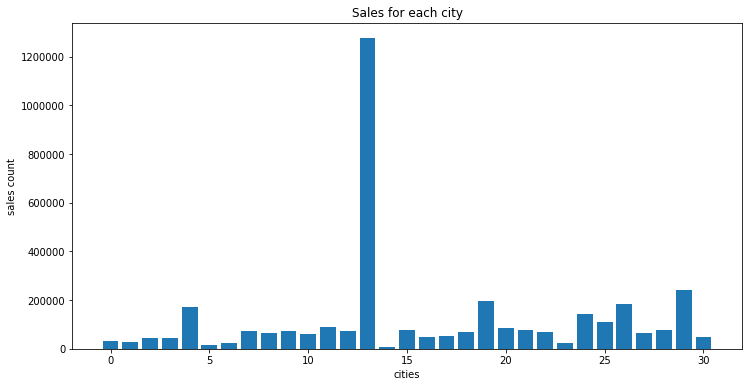

In [34]:
plt.figure(figsize=(12,6))
plt.bar(train_eda_city['city_id'], train_eda_city['item_cnt_city'] )  
plt.title("Sales for each city")
plt.xlabel('cities')
plt.ylabel('sales count')

<h2>Sales for each category</h2>

In [35]:
train_eda_cat = train_eda.groupby(['item_category_id']).agg({'item_cnt_day' : ['sum']})
train_eda_cat.columns = ['item_cnt_category']
train_eda_cat.reset_index(inplace=True)
train_eda_cat.head()

,item_category_id,item_cnt_category
0,0,3.0
1,1,2.0
2,2,19597.0
3,3,29807.0
4,4,2407.0


Text(0, 0.5, 'sales count')

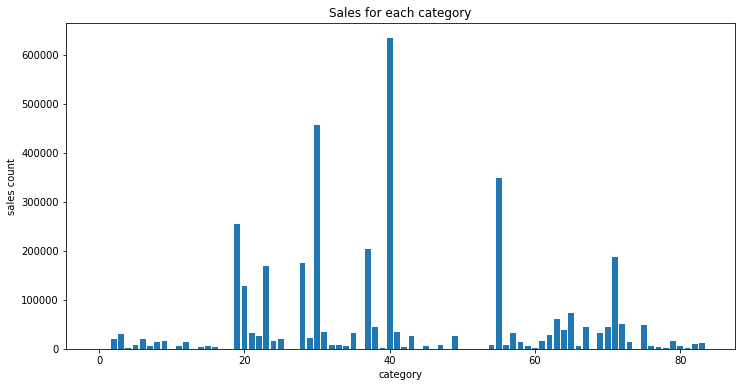

In [36]:
plt.figure(figsize=(12,6))
plt.bar(train_eda_cat['item_category_id'], train_eda_cat['item_cnt_category'] )  
plt.title("Sales for each category")
plt.xlabel('category')
plt.ylabel('sales count')

<h2>Sales for each category type</h2>

In [37]:
train_eda_type = train_eda.groupby(['type_id']).agg({'item_cnt_day' : ['sum']})
train_eda_type.columns = ['item_cnt_type']
train_eda_type.reset_index(inplace=True)
train_eda_type.head()

,type_id,item_cnt_type
0,0,3.0
1,1,85056.0
2,2,13699.0
3,3,15949.0
4,4,32155.0


Text(0, 0.5, 'sales count')

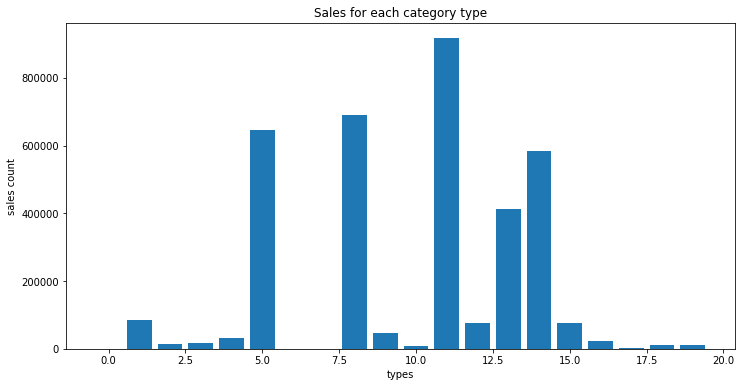

In [38]:
plt.figure(figsize=(12,6))
plt.bar(train_eda_type['type_id'], train_eda_type['item_cnt_type'] )  
plt.title("Sales for each category type")
plt.xlabel('types')
plt.ylabel('sales count')

<h2>Explore Test set</h2>

In [39]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [41]:
print("Total number of unique shops in test set: ", len(test['shop_id'].unique()))
print("Total number of unique items in test set: ", len(test['item_id'].unique()))
print("Total number of combinations of shops and items: ", len(test['shop_id'].unique()) * len(test['item_id'].unique()))
print("Number of new items in test set compared to train set: ", len(set(test['item_id'])) - len((set(test['item_id'])).intersection(set(train['item_id']))))

Total number of unique shops in test set:  42
Total number of unique items in test set:  5100
Total number of combinations of shops and items:  214200
Number of new items in test set compared to train set:  363


<h2>Extend Train set</h2>
<p>Train set contains only pairs which were sold or returned in the past, but not the all combinations of the shops and items.</p>
<p>To get the real behavior of the sales day, we need to calculate monthly sales and extend it with zero sales for each unique pair within the month.</p>

In [0]:
train_extend = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train['date_block_num']==i]
    # get all combinations of i, shop_id and item_id in month i. Then append it to train_extend
    train_extend.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique())), dtype='int16'))

In [43]:
train_extend = pd.DataFrame(np.vstack(train_extend), columns=cols)
train_extend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913804 entries, 0 to 10913803
Data columns (total 3 columns):
date_block_num    int16
shop_id           int16
item_id           int16
dtypes: int16(3)
memory usage: 62.4 MB


In [0]:
# change data type to reduce memory usage
train_extend['date_block_num'] = train_extend['date_block_num'].astype(np.int8)
train_extend['shop_id'] = train_extend['shop_id'].astype(np.int8)

train_extend.sort_values(cols,inplace=True)

<p>Add date_block_num to test set and append test set to the train_extend.</p>

In [0]:
test['date_block_num'] = 34
# change data type to reduce memory usage
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

train_extend = pd.concat([train_extend, test], ignore_index=True, sort=False, keys=cols)
train_extend.fillna(0,inplace=True) # month 34

<p>Add features from shops/items/items_categories to train_extend</p>

In [0]:
train_extend = pd.merge(train_extend, shops, on=['shop_id'],how='left')
train_extend = pd.merge(train_extend, items, on=['item_id'],how='left')
train_extend = pd.merge(train_extend, item_categories, on=['item_category_id'],how='left')

# change data type to reduce memory usage
train_extend['city_id'] = train_extend['city_id'].astype(np.int8)
train_extend['item_category_id'] = train_extend['item_category_id'].astype(np.int8)
train_extend['type_id'] = train_extend['type_id'].astype(np.int8)
train_extend['subtype_id'] = train_extend['subtype_id'].astype(np.int8)

In [47]:
train_extend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 8 columns):
date_block_num      int8
shop_id             int8
item_id             int16
ID                  float64
city_id             int8
item_category_id    int8
type_id             int8
subtype_id          int8
dtypes: float64(1), int16(1), int8(6)
memory usage: 254.7 MB


In [48]:
train_extend.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,subtype_id
0,0,0,19,0.0,29,40,11,4
1,0,0,27,0.0,29,19,5,10
2,0,0,28,0.0,29,30,8,55
3,0,0,29,0.0,29,23,5,16
4,0,0,32,0.0,29,40,11,4


<h1>Feature Engineering</h1>

<h2>Month and day</h2>

In [0]:
train_extend['month'] = train_extend['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_extend['days'] = train_extend['month'].map(days).astype(np.int8)

<h2>Total monthly sales count for each item in each shop</h2>

In [0]:
# Total monthly sales count for each item in each shop
item_cnt_month_agg = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':['sum']})
item_cnt_month_agg.columns = ['item_cnt_month']
item_cnt_month_agg.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, item_cnt_month_agg, on=cols, how='left')

In [0]:
train_extend['item_cnt_month']=(train_extend['item_cnt_month']
                          .fillna(0)
                          .clip(0,20)
                          .astype(np.float16))

<h2>Statistical features</h2>

<p>Monthly average sale</p>

In [0]:
temp = train_extend.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
temp.columns = ['item_cnt_month_avg']
temp.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, temp, on=['date_block_num'], how='left')

In [0]:
train_extend['item_cnt_month_avg'] = train_extend['item_cnt_month_avg'].astype(np.float16)

<p>Monthly average sale for each item</p>

In [0]:
temp = train_extend.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
temp.columns=['item_cnt_month_avg_item']
temp.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, temp, on=['date_block_num','item_id'],how='left')

In [0]:
train_extend['item_cnt_month_avg_item'] = train_extend['item_cnt_month_avg_item'].astype(np.float16)

<p>Monthly average sale for each shop</p>

In [0]:
temp = train_extend.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
temp.columns = ['item_cnt_month_avg_shop']
temp.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, temp, on=['date_block_num','shop_id'], how='left')

In [0]:
train_extend['item_cnt_month_avg_shop'] = train_extend['item_cnt_month_avg_shop'].astype(np.float16)

<p>Monthly average sale for each category</p>

In [0]:
temp = train_extend.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
temp.columns=['item_cnt_month_avg_cat']
temp.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, temp, on=['date_block_num','item_category_id'], how='left')

In [0]:
train_extend['item_cnt_month_avg_cat'] = train_extend['item_cnt_month_avg_cat'].astype(np.float16)

<p>Monthly average sale for each category in each shop</p>

In [0]:
temp = train_extend.groupby(['date_block_num','shop_id','item_category_id']).agg({'item_cnt_month':['mean']})
temp.columns=['item_cnt_month_avg_cat_shop']
temp.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, temp, on=['date_block_num','shop_id','item_category_id'], how='left')

In [0]:
train_extend['item_cnt_month_avg_cat_shop'] = train_extend['item_cnt_month_avg_cat_shop'].astype(np.float16)

<p>Monthly average sale for each city</p>

In [0]:
temp = train_extend.groupby(['date_block_num','city_id']).agg({'item_cnt_month':['mean']})
temp.columns = ['item_cnt_month_avg_city']
temp.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, temp, on=['date_block_num','city_id'], how='left')

In [0]:
train_extend['item_cnt_month_avg_city'] = train_extend['item_cnt_month_avg_city'].astype(np.float16)

<p>Monthly average sale for each item in each city</p>

In [0]:
temp = train_extend.groupby(['date_block_num','item_id','city_id']).agg({'item_cnt_month':['mean']})
temp.columns = ['item_cnt_month_avg_item_city']
temp.reset_index(inplace=True)

In [0]:
train_extend = pd.merge(train_extend, temp, on=['date_block_num','item_id','city_id'], how='left')

In [0]:
train_extend['item_cnt_month_avg_item_city'] = train_extend['item_cnt_month_avg_item_city'].astype(np.float16)

<h2>Trend features</h2>

Trend of item sales count

In [0]:
def lag_feature(df,lags,col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        
    return df

In [0]:
train_extend = lag_feature(train_extend, [1,2,3], 'item_cnt_month')

<p>Trend of average item sales count</p>

In [0]:
# monthly average sales
train_extend = lag_feature(train_extend, [1,2,3], 'item_cnt_month_avg')
# monthly average sales for each item
train_extend = lag_feature(train_extend, [1,2,3], 'item_cnt_month_avg_item')
# monthly average sales for each shop
train_extend = lag_feature(train_extend, [1,2,3], 'item_cnt_month_avg_shop')
# monthly average sales for each categorty
train_extend = lag_feature(train_extend, [1,2,3], 'item_cnt_month_avg_cat')
# monthly average sales for each categorty in each shop
train_extend = lag_feature(train_extend, [1,2,3], 'item_cnt_month_avg_cat_shop')
# monthly average sales for each city
train_extend = lag_feature(train_extend, [1,2,3], 'item_cnt_month_avg_city')
# monthly average sales for each item in each city
train_extend = lag_feature(train_extend,[1,2,3],'item_cnt_month_avg_item_city')

<p>Price trend</p>

In [0]:
temp = train.groupby(['item_id']).agg({'item_price':['mean']})
temp.columns=['item_avg_item_price']
temp.reset_index(inplace=True)

train_extend = pd.merge(train_extend, temp, on=['item_id'],how='left')
train_extend['item_avg_item_price'] = train_extend['item_avg_item_price'].astype(np.float16)

In [0]:
temp = train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
temp.columns=['item_month_avg_item_price']
temp.reset_index(inplace=True)

train_extend = pd.merge(train_extend, temp, on=['date_block_num','item_id'],how='left')
train_extend['item_month_avg_item_price'] = train_extend['item_month_avg_item_price'].astype(np.float16)

lags=[1,2,3,4,5,6]
train_extend = lag_feature(train_extend, lags, 'item_month_avg_item_price')

for i in lags:
    train_extend['delta_price_trend_' + str(i)] = \
    (train_extend['item_month_avg_item_price_lag_'+ str(i)] - train_extend['item_avg_item_price']) / train_extend['item_avg_item_price']
    
def select_trend(row):
    for i in lags:
        if row['delta_price_trend_' + str(i)]:
            return row['delta_price_trend_' + str(i)]        
    return 0

train_extend['delta_price_trend'] = train_extend.apply(select_trend, axis=1)
train_extend['delta_price_trend'] = train_extend['delta_price_trend'].astype(np.float16)
train_extend['delta_price_trend'].fillna(0,inplace=True)

features_to_drop=['item_avg_item_price','item_month_avg_item_price']
for i in lags:
    features_to_drop += ['item_month_avg_item_price_lag_'+ str(i)]
    features_to_drop += ['delta_price_trend_' + str(i)]
    
train_extend.drop(features_to_drop,axis=1,inplace=True)

<h2>First sales and Last sales</h2>

<p>Number of months since the last sale for each shop/item pair.</p>

In [0]:
dic = {}
train_extend['last_sale_item_shop'] = -1
train_extend['last_sale_item_shop'] = train_extend['last_sale_item_shop'].astype(np.int8)

for idx, row in train_extend.iterrows():
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in dic:
        if row.item_cnt_month!=0:
            dic[key] = row.date_block_num
    else:
        last_date_block_num = dic[key]
        train_extend.at[idx, 'last_sale_item_shop'] = row.date_block_num - last_date_block_num
        dic[key] = row.date_block_num

<p>Number of months since the last sale for each item.</p>

In [0]:
dic = {}
train_extend['last_sale_item'] = -1
train_extend['last_sale_item'] = train_extend['last_sale_item'].astype(np.int8)

for idx, row in train_extend.iterrows():
    key = row.item_id
    if key not in dic:
        if row.item_cnt_month!=0:
            dic[key] = row.date_block_num
    else:
        last_date_block_num = dic[key]
        if row.date_block_num > last_date_block_num:
            train_extend.at[idx, 'last_sale_item'] = row.date_block_num - last_date_block_num
            dic[key] = row.date_block_num

<p>Number of months since the first sale for each shop/item pair.</p>

In [0]:
train_extend['first_sale_item_shop'] = train_extend['date_block_num'] - train_extend.groupby(['item_id','shop_id'])['date_block_num'].transform('min')

<p>Number of months since the first sale for each item.</p>

In [0]:
train_extend['first_sale_item'] = train_extend['date_block_num'] - train_extend.groupby('item_id')['date_block_num'].transform('min')

<h1>Data to modeling</h1>

<p>Drop first 3 months</p>

In [0]:
train_extend = train_extend[train_extend.date_block_num > 2]

In [98]:
train_extend.head()

,date_block_num,shop_id,item_id,ID,city_id,item_category_id,type_id,subtype_id,month,days,item_cnt_month,item_cnt_month_avg,item_cnt_month_avg_item,item_cnt_month_avg_shop,item_cnt_month_avg_cat,item_cnt_month_avg_cat_shop,item_cnt_month_avg_city,item_cnt_month_avg_item_city,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_avg_lag_1,item_cnt_month_avg_lag_2,item_cnt_month_avg_lag_3,item_cnt_month_avg_item_lag_1,item_cnt_month_avg_item_lag_2,item_cnt_month_avg_item_lag_3,item_cnt_month_avg_shop_lag_1,item_cnt_month_avg_shop_lag_2,item_cnt_month_avg_shop_lag_3,item_cnt_month_avg_cat_lag_1,item_cnt_month_avg_cat_lag_2,item_cnt_month_avg_cat_lag_3,item_cnt_month_avg_cat_shop_lag_1,item_cnt_month_avg_cat_shop_lag_2,item_cnt_month_avg_cat_shop_lag_3,item_cnt_month_avg_city_lag_1,item_cnt_month_avg_city_lag_2,item_cnt_month_avg_city_lag_3,item_cnt_month_avg_item_city_lag_1,item_cnt_month_avg_item_city_lag_2,item_cnt_month_avg_item_city_lag_3,delta_price_trend,last_sale_item_shop,last_sale_item,first_sale_item_shop,first_sale_item
1122795,3,2,27,0.0,0,19,5,10,3,30,0.0,0.275391,0.021744,0.071838,0.687988,0.474609,0.071838,0.0,0.0,0.0,1.0,0.355469,0.324463,0.347168,0.086975,0.065247,0.155518,0.090454,0.059875,0.141235,1.093750,0.894531,0.834961,0.658203,0.292969,0.485107,0.090454,0.059875,0.141235,0.0,0.0,1.0,0.367676,1,1,3,3
1122796,3,2,28,0.0,0,30,8,55,3,30,0.0,0.275391,0.130493,0.071838,1.013672,0.387207,0.071838,0.0,0.0,0.0,0.0,0.355469,0.324463,0.347168,0.152222,0.173950,0.177734,0.090454,0.059875,0.141235,1.303711,0.994629,1.126953,0.502930,0.274414,0.537109,0.090454,0.059875,0.141235,0.0,0.0,0.0,0.283936,-1,1,3,3
1122797,3,2,30,0.0,0,40,11,4,3,30,0.0,0.275391,2.826172,0.071838,0.231445,0.018585,0.071838,0.0,1.0,0.0,NaN,0.355469,0.324463,NaN,8.281250,12.453125,NaN,0.090454,0.059875,NaN,0.287109,0.266113,NaN,0.026779,0.016724,NaN,0.090454,0.059875,NaN,1.0,0.0,NaN,0.215454,1,1,2,2
1122798,3,2,31,0.0,0,37,11,1,3,30,1.0,0.275391,1.260742,0.071838,0.175049,0.022491,0.071838,1.0,1.0,4.0,NaN,0.355469,0.324463,NaN,4.761719,11.195312,NaN,0.090454,0.059875,NaN,0.197876,0.196045,NaN,0.022552,0.030609,NaN,0.090454,0.059875,NaN,1.0,4.0,NaN,0.190186,1,1,2,2
1122799,3,2,32,0.0,0,40,11,4,3,30,0.0,0.275391,2.109375,0.071838,0.231445,0.018585,0.071838,0.0,0.0,0.0,0.0,0.355469,0.324463,0.347168,3.869141,4.476562,5.378906,0.090454,0.059875,0.141235,0.287109,0.266113,0.293945,0.026779,0.016724,0.073120,0.090454,0.059875,0.141235,0.0,0.0,0.0,0.376953,-1,1,3,3


<p>Lag features create a lot of nulls. Fill those nulls with 0</p>

In [0]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df

In [0]:
train_extend = fill_na(train_extend)

In [101]:
train_extend.columns

Index(['date_block_num', 'shop_id', 'item_id', 'ID', 'city_id',
       'item_category_id', 'type_id', 'subtype_id', 'month', 'days',
       'item_cnt_month', 'item_cnt_month_avg', 'item_cnt_month_avg_item',
       'item_cnt_month_avg_shop', 'item_cnt_month_avg_cat',
       'item_cnt_month_avg_cat_shop', 'item_cnt_month_avg_city',
       'item_cnt_month_avg_item_city', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'item_cnt_month_avg_lag_1', 'item_cnt_month_avg_lag_2',
       'item_cnt_month_avg_lag_3', 'item_cnt_month_avg_item_lag_1',
       'item_cnt_month_avg_item_lag_2', 'item_cnt_month_avg_item_lag_3',
       'item_cnt_month_avg_shop_lag_1', 'item_cnt_month_avg_shop_lag_2',
       'item_cnt_month_avg_shop_lag_3', 'item_cnt_month_avg_cat_lag_1',
       'item_cnt_month_avg_cat_lag_2', 'item_cnt_month_avg_cat_lag_3',
       'item_cnt_month_avg_cat_shop_lag_1',
       'item_cnt_month_avg_cat_shop_lag_2',
       'item_cnt_month_avg_cat_shop_lag_3'

In [102]:
train_extend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10005209 entries, 1122795 to 11128003
Data columns (total 47 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
ID                                    float64
city_id                               int8
item_category_id                      int8
type_id                               int8
subtype_id                            int8
month                                 int8
days                                  int8
item_cnt_month                        float16
item_cnt_month_avg                    float16
item_cnt_month_avg_item               float16
item_cnt_month_avg_shop               float16
item_cnt_month_avg_cat                float16
item_cnt_month_avg_cat_shop           float16
item_cnt_month_avg_city               float16
item_cnt_month_avg_item_city          float16
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2           

<h2>Select features</h2>

In [0]:
selected_features = ['date_block_num',
                     'shop_id',
                     'item_id',
                     'month',
                     'days',
                     'city_id',
                     'item_category_id',
                     'type_id',
                     'subtype_id',
                     'item_cnt_month',
                     'item_cnt_month_lag_1',
                     'item_cnt_month_lag_2',
                     'item_cnt_month_lag_3',
                     'item_cnt_month_avg_lag_1',
                     'item_cnt_month_avg_lag_2',
                     'item_cnt_month_avg_lag_3',
                     'item_cnt_month_avg_item_lag_1',
                     'item_cnt_month_avg_item_lag_2',
                     'item_cnt_month_avg_item_lag_3',
                     'item_cnt_month_avg_shop_lag_1',
                     'item_cnt_month_avg_shop_lag_2',
                     'item_cnt_month_avg_shop_lag_3',
                     'item_cnt_month_avg_cat_lag_1',
                     'item_cnt_month_avg_cat_lag_2',
                     'item_cnt_month_avg_cat_lag_3',
                     'item_cnt_month_avg_cat_shop_lag_1',
                     'item_cnt_month_avg_cat_shop_lag_2',
                     'item_cnt_month_avg_cat_shop_lag_3',
                     'item_cnt_month_avg_city_lag_1',
                     'item_cnt_month_avg_city_lag_2',
                     'item_cnt_month_avg_city_lag_3',
                     'item_cnt_month_avg_item_city_lag_1',
                     'item_cnt_month_avg_item_city_lag_2',
                     'item_cnt_month_avg_item_city_lag_3',
                     'delta_price_trend',
                     'first_sale_item_shop',
                     'first_sale_item',
                     'last_sale_item_shop',
                     'last_sale_item']
                     
data = train_extend[selected_features]

<h1>Save data</h1>

In [0]:
data.to_pickle('data_to_model.pkl')